# NN2: Implementacja propagacji wstecznej błędu

#### Magdalena Jeczeń

Wczytanie danych

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
train_data_sq_s = np.genfromtxt('./mio1/regression/square-simple-training.csv', delimiter=',', skip_header=1)
test_data_sq_s = np.genfromtxt('./mio1/regression/square-simple-test.csv', delimiter=',', skip_header=1)
train_data_sq_s = train_data_sq_s[:, 1:]
test_data_sq_s = test_data_sq_s[:, 1:]

In [3]:
X_train_sq_s = train_data_sq_s[:, :-1]
y_train_sq_s = train_data_sq_s[:, -1].reshape(-1, 1)
X_test_sq_s = test_data_sq_s[:, :-1]
y_test_sq_s = test_data_sq_s[:, -1].reshape(-1, 1)

In [4]:
train_data_st_s = np.genfromtxt('./mio1/regression/steps-small-training.csv', delimiter=',', skip_header=1)
test_data_st_s = np.genfromtxt('./mio1/regression/steps-small-test.csv', delimiter=',', skip_header=1)
train_data_st_s = train_data_st_s[:, 1:]
test_data_st_s = test_data_st_s[:, 1:]

In [5]:
X_train_st_s = train_data_st_s[:, :-1]
y_train_st_s = train_data_st_s[:, -1].reshape(-1, 1)
X_test_st_s = test_data_st_s[:, :-1]
y_test_st_s = test_data_st_s[:, -1].reshape(-1, 1)

In [6]:
train_data_mm_l = np.genfromtxt('./mio1/regression/multimodal-large-training.csv', delimiter=',', skip_header=1)
test_data_mm_l = np.genfromtxt('./mio1/regression/multimodal-large-test.csv', delimiter=',', skip_header=1)

In [7]:
X_train_mm_l = train_data_mm_l[:, :-1]
y_train_mm_l = train_data_mm_l[:, -1].reshape(-1, 1)
X_test_mm_l = test_data_mm_l[:, :-1]
y_test_mm_l = test_data_mm_l[:, -1].reshape(-1, 1)

Inne funkcje

In [8]:
import matplotlib.pyplot as plt
def plot_scatter(X, y_true, y_pred, title="Scatter Plot"): # funkcja służąca do tworzenia wykresu danych prawdziwych oraz przewidzianych
    plt.scatter(X, y_true, label="Actual (y_true)", color='blue')
    plt.scatter(X, y_pred, label="Predicted (y_pred)", color='red', marker='x')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_multiple_mse(mse_list):
    plt.figure(figsize=(10, 6))
    
    for mse_df, label in mse_list:
        plt.plot(mse_df['Epoch'], mse_df['MSE_Test'], label=label)

    plt.xlabel('Epoch')
    plt.ylabel('MSE Test')
    plt.title('MSE Test Comparison')
    plt.legend()
    plt.show()

In [10]:
def plot_multiple_mse_log(mse_list):
    plt.figure(figsize=(10, 6))
    
    for mse_df, label in mse_list:
        plt.plot(mse_df['Epoch'], mse_df['MSE_Test'], label=label)

    plt.xlabel('Epoch')
    plt.ylabel('MSE Test')
    plt.title('MSE Test Comparison with logaritmic mse values')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()
    plt.show()

In [214]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

def plot_network(b,w):
    w1 = np.round(w[0],2).tolist()[0]
    b1 = np.round(b[0],2).tolist()[0]
    G = nx.Graph()
    
    G.add_nodes_from("x",layer = 0)
    G.add_nodes_from(b1, layer = 1)
    G.add_weighted_edges_from([["x", bi, wi] for (bi,wi) in zip(b1,w1)])
    for i in range(1, len(w)-1):
        b1 = np.round(b[i-1],2).tolist()[0]
        b2 = np.round(b[i],2).tolist()[0]
        G.add_nodes_from(b2, layer = i+1)
        G.add_edges_from(itertools.product(b1,b2))

    b1 = np.round(b[-2],2).tolist()[0]
    w2 = np.round(w[-1].T,2).tolist()[0]
    b2 = np.round(b[-1],2).tolist()[0]
    G.add_nodes_from(b2, layer = len(w))
    G.add_weighted_edges_from([[pi, b2[0], wi] for (pi,wi) in zip(b1,w2)])

    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_size = 1200)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.title("Network after training")
    plt.axis("equal")
    plt.show()

In [130]:
def transform_format(data):
    result = []
    
    for arr in data:
        if arr.ndim == 1:
            result.append(np.matrix(arr))
        else:
            result.append(np.matrix(arr).T)
    
    return result

Sieć neuronowa

In [73]:
import random
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        #self.biases = [np.random.uniform(-1, 1, (y, 1)) for y in sizes[1:]]
        self.biases = [np.zeros((y, 1)) for y in sizes[1:]] 
        self.weights = [np.random.uniform(0, 1, (y, x))
                        for x, y in zip(sizes[:-1], sizes[1:])]  
        self.mse = None
        self.mean_y = None
        self.std_y = None
        self.y_and_y_pred = None
        self.y_pred = None
        self.training_data = None
        self.normalized_data = None
        self.normalized_data_prime = None
        self.test_data = None
        self.normalized_test_data = None
        self.y_and_y_pred_test = None
        self.mse_test = None
        self.mean_x = None
        self.std_x = None
        
        self.weights_0 = None  
        self.biases_0 = None   
        
        self.mse_history = []
        
    def generate_weights(self, method='uniform'):
        if method == 'uniform':
            self.weights_0 = [np.random.uniform(0, 1, (y, x))
                              for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        elif method == 'he':
            self.weights_0 = [np.random.normal(0, np.sqrt(2.0 / x), (y, x))
                              for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        elif method == 'xavier':
            self.weights_0 = [np.random.normal(0, np.sqrt(1.0 / x), (y, x))
                              for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        else:
            raise ValueError("Invalid method for weight initialization")    
        self.weights = self.weights_0.copy()
        
        
    def generate_biases(self, method='zeros'):
        if method == 'zeros':
            self.biases_0 = [np.zeros((y, 1)) for y in self.sizes[1:]]
        elif method == 'uniform':
            self.biases_0 = [np.random.uniform(0, 1, (y, 1)) for y in self.sizes[1:]]
        elif method == 'he':
            self.biases_0 = [np.random.normal(0, np.sqrt(2.0 / x), (y, 1))
                             for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        elif method == 'xavier':
            self.biases_0 = [np.random.normal(0, np.sqrt(1.0 / x), (y, 1))
                             for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        else:
            raise ValueError("Invalid method for bias initialization")

        self.biases = self.biases_0.copy()    
        
        
    def set_custom_weights(self, custom_weights):
        self.weights_0 = custom_weights.copy()
        self.weights = self.weights_0.copy()

    def set_custom_biases(self, custom_biases):
        self.biases_0 = custom_biases.copy()
        self.biases = self.biases_0.copy()
        
        
    def sigmoid(self,z):
        return 1.0/(1.0+np.exp(-z))

    def sigmoid_pochodna(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))    
        
    def normalize_data_with_given_mean_std(self, data, i, given_mean, given_std):
        column = data[:, i]
        normalized_column = (column - given_mean) / given_std
    
        return normalized_column
    
        
    def normalize_data(self, data, i):
    
        column = data[:, i]
        mean = np.mean(column)
        std_dev = np.std(column)
        std_dev = std_dev if std_dev != 0 else 1

        normalized_column = (column - mean) / std_dev
    
        return normalized_column, mean, std_dev
    
    def restore_data(self,normalized_column_y, mean, std_dev, x_column):
        
    
        restored_column = normalized_column_y * std_dev + mean
        restored_data = np.column_stack((x_column, restored_column))
    
        return restored_data
    
    def glue_data_2(self,x, y):
        
    
        restored_data = np.column_stack((x, y))
    
        return restored_data

    def convert_to_array(self,data):
    
        converted_data = np.squeeze(data)
        return converted_data


    def feedforward(self, a): # dobrze
        a = a.reshape((-1, 1))
        for i, (b, w) in enumerate(zip(self.biases, self.weights)):
            if i<self.num_layers - 2:
                z = np.dot(w, a) + b
                a = self.sigmoid(np.dot(w, a) + b)
            else:
                z = np.dot(w, a) + b
                a = np.dot(w, a) + b
        return a
    

    def SGD(self, training_data, normalized_data, epochs, mini_batch_size, eta, test_data, normalized_test_data):
        
        
        self.training_data = training_data
        self.normalized_data = normalized_data
        normalized_x, mean_x, std_x  = self.normalize_data(self.normalized_data, 0)
        normalized_y, mean_y, std_y = self.normalize_data(self.normalized_data, 1)
        self.mean_y, self.std_y = mean_y, std_y
        self.mean_x, self.std_x = mean_x, std_x
        self.normalized_data = self.glue_data_2(normalized_x, normalized_y)
        self.normalized_data_prime = self.glue_data_2(normalized_x, normalized_y)
        n = len(self.normalized_data)
    
    
        self.test_data = test_data
        self.normalized_test_data = normalized_test_data
        normalized_x_test  = self.normalize_data_with_given_mean_std(self.normalized_test_data, 0,self.mean_x, self.std_x)
        normalized_y_test = self.normalize_data_with_given_mean_std(self.normalized_test_data, 1, self.mean_y, self.std_y)
        self.normalized_test_data = self.glue_data_2(normalized_x_test, normalized_y_test)
        for j in range(epochs):
            #np.random.shuffle(self.normalized_data)
            mini_batches = [
                self.normalized_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
                
            mse_test = self.evaluate_mse_0_for_test(self.test_data, self.normalized_test_data)
            self.mse_history.append((j, mse_test))    
                
                
            print("Epoch {0} complete, mse: {1}".format(j, self.evaluate_mse_0(self.training_data, self.normalized_data_prime)))
            print("Epoch {0} complete, mse for test: {1}".format(j, self.evaluate_mse_0_for_test(self.test_data, self.normalized_test_data)))
        print('cost:')
        print(self.mse_test)
        
        
    def evaluate_mse_0(self, training_data, normalized_data):
        
        feedforward_outputs = [self.convert_to_array(self.feedforward(x)) for (x, y) in normalized_data]
        feedforward_outputs = np.array(feedforward_outputs)
        data_glued = self.restore_data(feedforward_outputs,self.mean_y, self.std_y, training_data[:,1])
        mse = np.mean([(y_pred - y)**2 for (y, y_pred) in data_glued])
        self.y_and_y_pred = data_glued
        self.mse = mse
        return mse  
    
    
    def evaluate_mse_0_for_test(self, test_data, normalized_test_data):
        
        feedforward_outputs = [self.convert_to_array(self.feedforward(x)) for (x, y) in normalized_test_data]
        feedforward_outputs = np.array(feedforward_outputs)
        data_glued_test = self.restore_data(feedforward_outputs,self.mean_y, self.std_y, test_data[:,1])
        mse_test = np.mean([(y_pred - y)**2 for (y, y_pred) in data_glued_test])
        self.y_and_y_pred_test = data_glued_test
        self.mse_test = mse_test
        return mse_test
          

    def update_mini_batch(self, mini_batch, eta):
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        i = 0
        for x, y in mini_batch:
            i = i+1
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activation = x
        activations = [x]
        zs = [] 
        for i, (b, w) in enumerate(zip(self.biases, self.weights)): 
            z = np.dot(w, activation) + b
            zs.append(z)
            if i < self.num_layers - 2: 
                activation = self.sigmoid(z)
            else:
                activation = z
            activations.append(activation)

        delta_L = self.cost_derivative(zs[-1], y)
        
        delts = []
        delts.append(delta_L)
        delts.append(delta_L)
        
        nabla_b[-1] = delta_L
        nabla_w[-1] = np.dot(delta_L, activations[-2].transpose())

        delta = delta_L
        for l in range(2, self.num_layers):
            
            z = zs[-l]
            sp = self.sigmoid_pochodna(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)


    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
    
    


Dobieranie parametrów

##### SQUARE SIMPLE

In [52]:
net_sq_s = Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [53]:
net_sq_s.generate_weights(method='uniform')
net_sq_s.generate_biases(method='zeros')

In [54]:
net_sq_s.SGD(train_data_sq_s,train_data_sq_s, 400, 2, 0.4, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 13897.305710433247
Epoch 0 complete, mse for test: 12112.076154684362
Epoch 1 complete, mse: 28187.72978950794
Epoch 1 complete, mse for test: 24952.119134659864
Epoch 2 complete, mse: 4985.1817030613975
Epoch 2 complete, mse for test: 3739.3992001964107
Epoch 3 complete, mse: 3999.636033150821
Epoch 3 complete, mse for test: 3043.2182179264787
Epoch 4 complete, mse: 3264.520046378093
Epoch 4 complete, mse for test: 2640.070893404047
Epoch 5 complete, mse: 2166.8427699608173
Epoch 5 complete, mse for test: 1891.5200320281717
Epoch 6 complete, mse: 911.5830595638316
Epoch 6 complete, mse for test: 687.909680381697
Epoch 7 complete, mse: 963.1309284390799
Epoch 7 complete, mse for test: 543.9397341065745
Epoch 8 complete, mse: 1158.6274389398347
Epoch 8 complete, mse for test: 692.1976999108601
Epoch 9 complete, mse: 1067.06941976092
Epoch 9 complete, mse for test: 649.0981331624125
Epoch 10 complete, mse: 537.8099534084336
Epoch 10 complete, mse for test: 568.8236

In [284]:
print("Square-simple MSE dla train: ", net_sq_s.mse)
print("Square-simple MSE dla test: ", net_sq_s.mse_test)

Square-simple MSE dla train:  1.3068611743996954
Square-simple MSE dla test:  2.0884659423622183


In [56]:
y_pred_test_sq_s = net_sq_s.y_and_y_pred_test[:,1]
y_pred_train_sq_s = net_sq_s.y_and_y_pred[:,1]

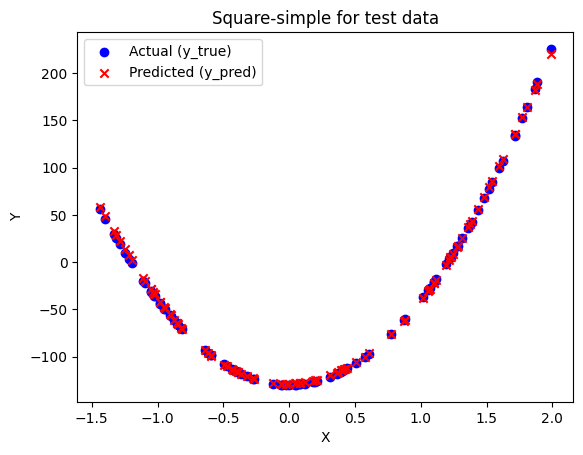

In [57]:
plot_scatter(X_test_sq_s, y_test_sq_s, y_pred_test_sq_s,title='Square-simple for test data')

In [312]:
w = net_sq_s.weights
b = net_sq_s.biases

In [313]:
w_0_tr = transform_format(w)
b_0_tr = transform_format(b)

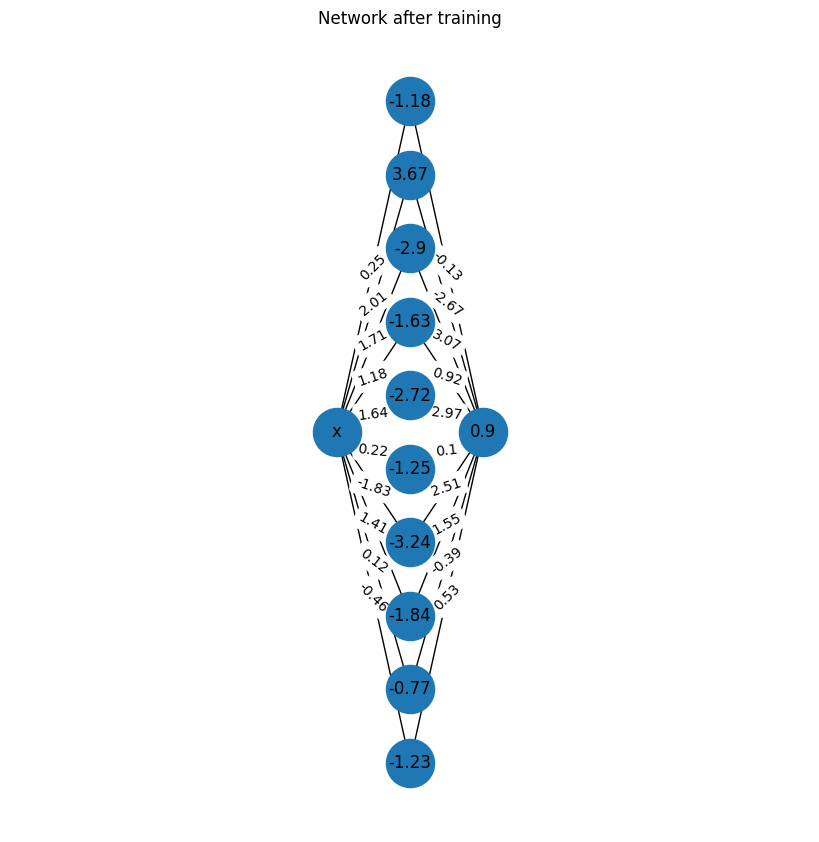

In [314]:
plot_network(b_0_tr, w_0_tr)

##### STEPS-SMALL

In [37]:
net_st_s = Network(sizes = [X_train_st_s.shape[1], 5,5, 1])

In [38]:
net_st_s.generate_weights(method='uniform')
net_st_s.generate_biases(method='zeros')

In [39]:
net_st_s.SGD(train_data_st_s,train_data_st_s, 30000,2 , 0.1, test_data_st_s, test_data_st_s)

Epoch 0 complete, mse: 6570.009818905954
Epoch 0 complete, mse for test: 7986.682996280379
Epoch 1 complete, mse: 6413.149520799252
Epoch 1 complete, mse for test: 7788.239994660012
Epoch 2 complete, mse: 6209.449282720248
Epoch 2 complete, mse for test: 7531.355014057169
Epoch 3 complete, mse: 5944.391774754779
Epoch 3 complete, mse for test: 7198.50468515337
Epoch 4 complete, mse: 5602.8599690829715
Epoch 4 complete, mse for test: 6771.889986060987
Epoch 5 complete, mse: 5172.386100705682
Epoch 5 complete, mse for test: 6237.561979907087
Epoch 6 complete, mse: 4648.645853550191
Epoch 6 complete, mse for test: 5592.089620782036
Epoch 7 complete, mse: 4042.386656713445
Epoch 7 complete, mse for test: 4850.607183484804
Epoch 8 complete, mse: 3384.6714325657476
Epoch 8 complete, mse for test: 4052.421926887808
Epoch 9 complete, mse: 2725.3386054427606
Epoch 9 complete, mse for test: 3258.288333389177
Epoch 10 complete, mse: 2121.18722488543
Epoch 10 complete, mse for test: 2535.693990144

In [283]:
print("steps-small MSE dla train: ", net_st_s.mse)
print("steps-small MSE dla test: ", net_st_s.mse_test)

steps-small MSE dla train:  2.9708229519945344
steps-small MSE dla test:  109.20024636254101


In [58]:
y_pred_test_st_s = net_st_s.y_and_y_pred_test[:,1]
y_pred_train_st_s = net_st_s.y_and_y_pred[:,1]

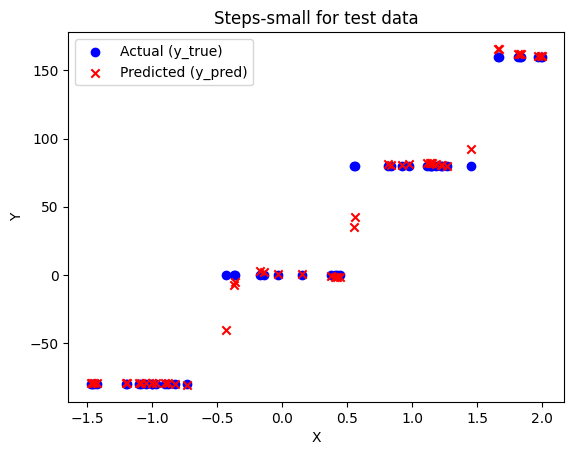

In [59]:
plot_scatter(X_test_st_s, y_test_st_s, y_pred_test_st_s,title='Steps-small for test data')

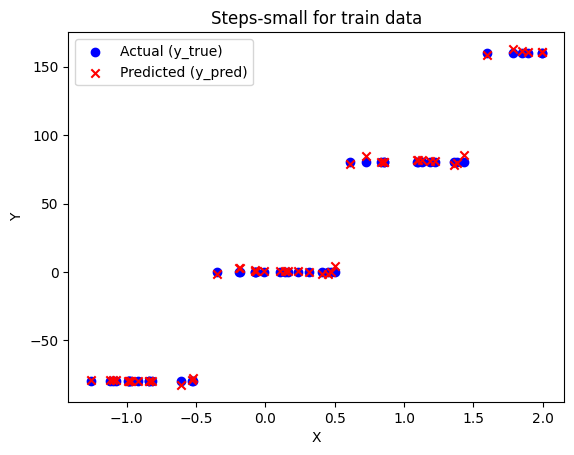

In [281]:
plot_scatter(X_train_st_s, y_train_st_s, y_pred_train_st_s,title='Steps-small for train data')

In [211]:
w = net_st_s.weights
b = net_st_s.biases

In [212]:
w_t = transform_format(w)
b_t = transform_format(b)

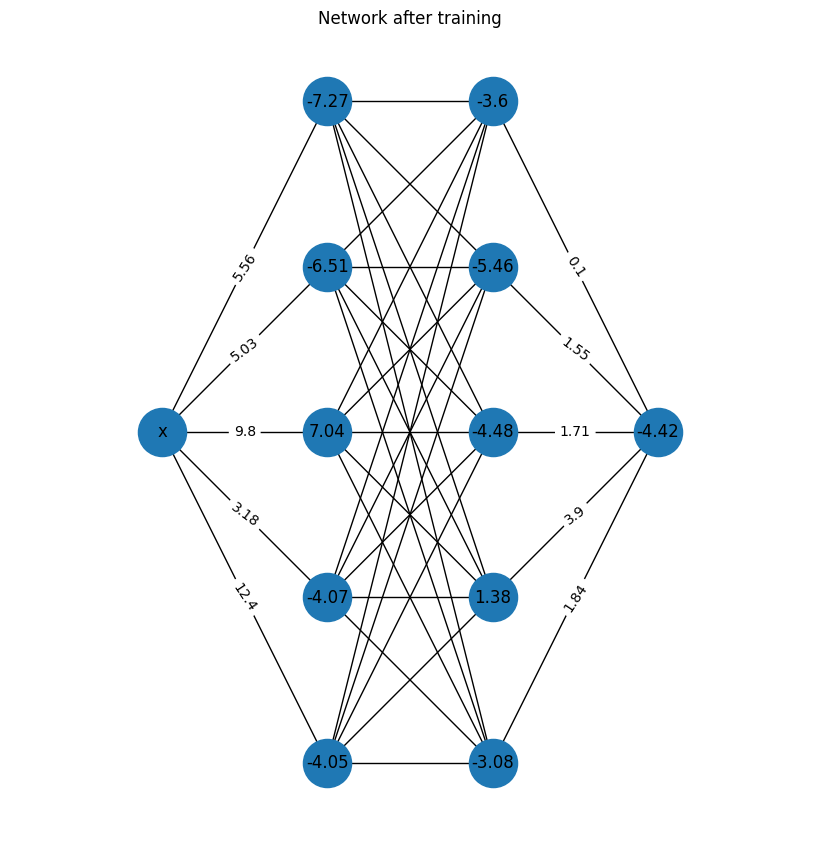

In [216]:
plot_network(b_t, w_t)

Wnioski:

Jak widzimy, niestety MSE dla danych testowych jest znacznie większe niż dla danych treningowych. Podejrzewam, że przyczyna leży w rozmiarze zbioru - zbiór treningowy jak i testowy mają tylko 50 wierszy

##### MULTIMODAL-LARGE

In [123]:
net_mm_l_3 = Network(sizes = [X_train_mm_l.shape[1], 10, 1])

In [124]:
net_mm_l_3.set_custom_weights([np.array([[0.33896174],
        [0.8992459 ],
        [0.25215822],
        [0.32801773],
        [0.52875477],
        [0.84810359],
        [0.5117569 ],
        [0.50701172],
        [0.49376815],
        [0.80380174]]),
 np.array([[0.91535257, 0.21895464, 0.29042353, 0.05092755, 0.93522261,
         0.43732158, 0.64022901, 0.53802057, 0.41986654, 0.40242711]])])

In [125]:
net_mm_l_3.generate_biases("zeros")

In [126]:
net_mm_l_3.SGD(train_data_mm_l,train_data_mm_l, 10000,50, 0.1, test_data_mm_l, test_data_mm_l)

Epoch 0 complete, mse: 4299.608057841716
Epoch 0 complete, mse for test: 4328.509325860811
Epoch 1 complete, mse: 4230.870400898696
Epoch 1 complete, mse for test: 4257.751188706167
Epoch 2 complete, mse: 4114.364203561344
Epoch 2 complete, mse for test: 4138.914058295406
Epoch 3 complete, mse: 3917.1767009888454
Epoch 3 complete, mse for test: 3939.7240633129727
Epoch 4 complete, mse: 3638.37101194707
Epoch 4 complete, mse for test: 3660.9136169613766
Epoch 5 complete, mse: 3322.510300016584
Epoch 5 complete, mse for test: 3346.603634158486
Epoch 6 complete, mse: 3020.655741250559
Epoch 6 complete, mse for test: 3045.0358091851695
Epoch 7 complete, mse: 2769.5684615530254
Epoch 7 complete, mse for test: 2791.704444531632
Epoch 8 complete, mse: 2589.339386732622
Epoch 8 complete, mse for test: 2608.162660656319
Epoch 9 complete, mse: 2473.949638244206
Epoch 9 complete, mse for test: 2490.0986914722007
Epoch 10 complete, mse: 2401.4330339116646
Epoch 10 complete, mse for test: 2416.2321

In [285]:
print("Multimodal-large MSE dla train: ", net_mm_l_3.mse)
print("Multimodal-large MSE dla test: ", net_mm_l_3.mse_test)

Multimodal-large MSE dla train:  17.11008893640455
Multimodal-large MSE dla test:  12.853568732810311


In [127]:
y_pred_test_mm_l = net_mm_l_3.y_and_y_pred_test[:,1]
y_pred_train_mm_l = net_mm_l_3.y_and_y_pred[:,1]

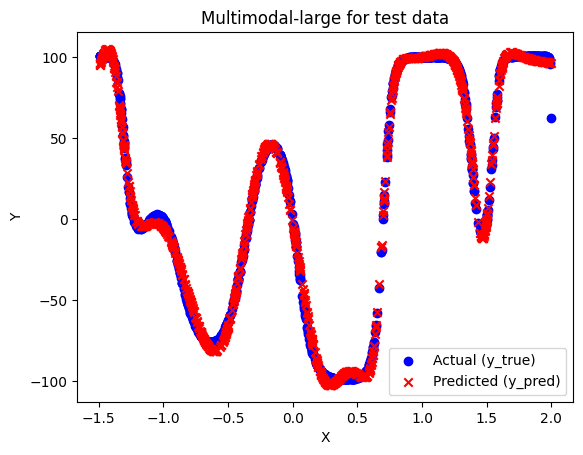

In [128]:
plot_scatter(X_test_mm_l, y_test_mm_l, y_pred_test_mm_l,title='Multimodal-large for test data')

In [217]:
w = net_mm_l_3.weights
b = net_mm_l_3.biases

In [218]:
w_t = transform_format(w)
b_t = transform_format(b)

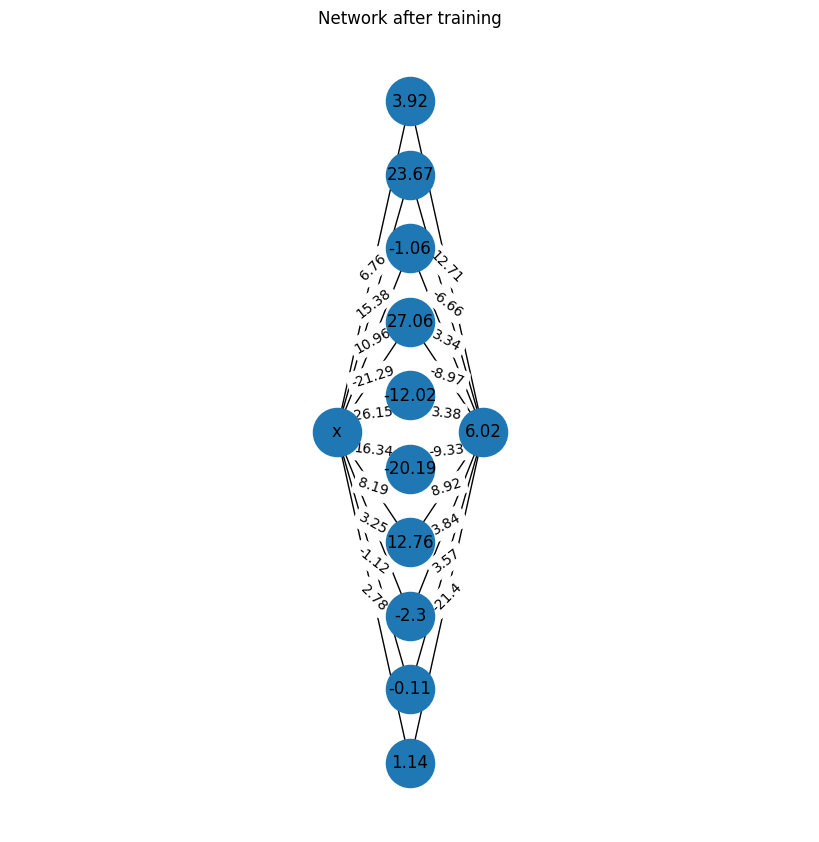

In [219]:
plot_network(b_t, w_t)

Wniosek

Sieć potrzebowała sporo czasu na wytrenowanie. Może to wynikać ze skomplikowania funkcji którą predykujemy, a także z wielkości danych (są duże, mają 10.000 obserwacji)

### MSE w zależności od liczby epok oraz rozmiaru batchy

In [220]:
net1= Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [221]:
net1.generate_weights(method='uniform')
net1.generate_biases(method='zeros')

In [222]:
weights_to_set = net1.weights_0

In [223]:
biases_to_set = net1.biases_0

In [231]:
weights_to_set

[array([[0.76864383],
        [0.374131  ],
        [0.13028387],
        [0.33447458],
        [0.88596672],
        [0.69084194],
        [0.41286643],
        [0.73052506],
        [0.52508837],
        [0.19715791]]),
 array([[0.24670741, 0.33153385, 0.34383518, 0.23937695, 0.69092754,
         0.16383539, 0.52277811, 0.98213788, 0.57113293, 0.47417782]])]

In [226]:
net1.SGD(train_data_sq_s,train_data_sq_s, 300, 2, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 7649.532239048543
Epoch 0 complete, mse for test: 5823.203781546106
Epoch 1 complete, mse: 7401.275084084598
Epoch 1 complete, mse for test: 5563.596079722888
Epoch 2 complete, mse: 7204.401520146592
Epoch 2 complete, mse for test: 5371.345412924749
Epoch 3 complete, mse: 7038.681440950171
Epoch 3 complete, mse for test: 5222.25899583741
Epoch 4 complete, mse: 6889.091703856102
Epoch 4 complete, mse for test: 5098.2294808388015
Epoch 5 complete, mse: 6744.7064441951725
Epoch 5 complete, mse for test: 4986.075233971762
Epoch 6 complete, mse: 6597.961344924011
Epoch 6 complete, mse for test: 4876.715792471999
Epoch 7 complete, mse: 6443.9290959411355
Epoch 7 complete, mse for test: 4764.273095354488
Epoch 8 complete, mse: 6279.671861844679
Epoch 8 complete, mse for test: 4645.227230030352
Epoch 9 complete, mse: 6103.727155988448
Epoch 9 complete, mse for test: 4517.728967361336
Epoch 10 complete, mse: 5915.723840821293
Epoch 10 complete, mse for test: 4381.08542718

In [249]:
net2 = Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [250]:
net2.set_custom_weights([np.array([[0.76864383],
        [0.374131  ],
        [0.13028387],
        [0.33447458],
        [0.88596672],
        [0.69084194],
        [0.41286643],
        [0.73052506],
        [0.52508837],
        [0.19715791]]),
 np.array([[0.24670741, 0.33153385, 0.34383518, 0.23937695, 0.69092754,
         0.16383539, 0.52277811, 0.98213788, 0.57113293, 0.47417782]])])

In [251]:
net2.generate_biases("zeros")

In [252]:
net2.SGD(train_data_sq_s,train_data_sq_s, 300, 5, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 7788.76112087308
Epoch 0 complete, mse for test: 5966.756945874495
Epoch 1 complete, mse: 7639.7686420943555
Epoch 1 complete, mse for test: 5786.148500007121
Epoch 2 complete, mse: 7532.998618078978
Epoch 2 complete, mse for test: 5675.774055865445
Epoch 3 complete, mse: 7437.758336391374
Epoch 3 complete, mse for test: 5580.027105329978
Epoch 4 complete, mse: 7352.021335254405
Epoch 4 complete, mse for test: 5496.163860897201
Epoch 5 complete, mse: 7274.159317893129
Epoch 5 complete, mse for test: 5422.299487873827
Epoch 6 complete, mse: 7202.724653252205
Epoch 6 complete, mse for test: 5356.751360003678
Epoch 7 complete, mse: 7136.4243234472
Epoch 7 complete, mse for test: 5298.006961583463
Epoch 8 complete, mse: 7074.10656169173
Epoch 8 complete, mse for test: 5244.712795524751
Epoch 9 complete, mse: 7014.752140672898
Epoch 9 complete, mse for test: 5195.667776191005
Epoch 10 complete, mse: 6957.466985545063
Epoch 10 complete, mse for test: 5149.817169698806


In [253]:
net3 = Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [254]:
net3.set_custom_weights([np.array([[0.76864383],
        [0.374131  ],
        [0.13028387],
        [0.33447458],
        [0.88596672],
        [0.69084194],
        [0.41286643],
        [0.73052506],
        [0.52508837],
        [0.19715791]]),
 np.array([[0.24670741, 0.33153385, 0.34383518, 0.23937695, 0.69092754,
         0.16383539, 0.52277811, 0.98213788, 0.57113293, 0.47417782]])])

In [255]:
net3.generate_biases("zeros")

In [256]:
net3.SGD(train_data_sq_s,train_data_sq_s, 300, 10, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 8684.59348458296
Epoch 0 complete, mse for test: 6989.0202855216085
Epoch 1 complete, mse: 7769.183066787471
Epoch 1 complete, mse for test: 5936.733116682445
Epoch 2 complete, mse: 7692.578341780119
Epoch 2 complete, mse for test: 5834.543670321034
Epoch 3 complete, mse: 7635.300407841293
Epoch 3 complete, mse for test: 5772.572924471204
Epoch 4 complete, mse: 7581.417666037967
Epoch 4 complete, mse for test: 5717.4336095767885
Epoch 5 complete, mse: 7530.512125655409
Epoch 5 complete, mse for test: 5666.237281420961
Epoch 6 complete, mse: 7482.363535747492
Epoch 6 complete, mse for test: 5618.407138118306
Epoch 7 complete, mse: 7436.745436566823
Epoch 7 complete, mse for test: 5573.646021678674
Epoch 8 complete, mse: 7393.440990986269
Epoch 8 complete, mse for test: 5531.705142948692
Epoch 9 complete, mse: 7352.245597497902
Epoch 9 complete, mse for test: 5492.353535888514
Epoch 10 complete, mse: 7312.966277640453
Epoch 10 complete, mse for test: 5455.373027094

In [257]:
net4 = Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [258]:
net4.set_custom_weights([np.array([[0.76864383],
        [0.374131  ],
        [0.13028387],
        [0.33447458],
        [0.88596672],
        [0.69084194],
        [0.41286643],
        [0.73052506],
        [0.52508837],
        [0.19715791]]),
 np.array([[0.24670741, 0.33153385, 0.34383518, 0.23937695, 0.69092754,
         0.16383539, 0.52277811, 0.98213788, 0.57113293, 0.47417782]])])

In [259]:
net4.generate_biases("zeros")

In [260]:
net4.SGD(train_data_sq_s,train_data_sq_s, 300, 100, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 39382.397987637094
Epoch 0 complete, mse for test: 37061.807079379
Epoch 1 complete, mse: 28835.24854877819
Epoch 1 complete, mse for test: 26866.711711261527
Epoch 2 complete, mse: 21879.3907831326
Epoch 2 complete, mse for test: 20106.608823172053
Epoch 3 complete, mse: 17259.06366776475
Epoch 3 complete, mse for test: 15587.055244920462
Epoch 4 complete, mse: 14173.941470140744
Epoch 4 complete, mse for test: 12545.620392969586
Epoch 5 complete, mse: 12105.708886293816
Epoch 5 complete, mse for test: 10487.568200126529
Epoch 6 complete, mse: 10714.785737562719
Epoch 6 complete, mse for test: 9087.987127330885
Epoch 7 complete, mse: 9776.821574415773
Epoch 7 complete, mse for test: 8131.586402341697
Epoch 8 complete, mse: 9142.687426619872
Epoch 8 complete, mse for test: 7474.746875367347
Epoch 9 complete, mse: 8712.809777263734
Epoch 9 complete, mse for test: 7021.157675712824
Epoch 10 complete, mse: 8420.48216174929
Epoch 10 complete, mse for test: 6705.95934

In [322]:
mse_df_1 = pd.DataFrame(net1.mse_history, columns=['Epoch', 'MSE_Test'])
mse_df_2 = pd.DataFrame(net2.mse_history, columns=['Epoch', 'MSE_Test'])
mse_df_3 = pd.DataFrame(net3.mse_history, columns=['Epoch', 'MSE_Test'])
mse_df_4 = pd.DataFrame(net4.mse_history, columns=['Epoch', 'MSE_Test'])

In [323]:
print("Liczba obserwacji w zbiorze treningowym: ", train_data_sq_s.shape[0])

Liczba obserwacji w zbiorze treningowym:  100


In [324]:
mse_list = [(mse_df_1, 'batch size: 2'), (mse_df_2, 'batch size: 5'), (mse_df_3, 'batch size: 10'), (mse_df_4, 'Without mini batches')]


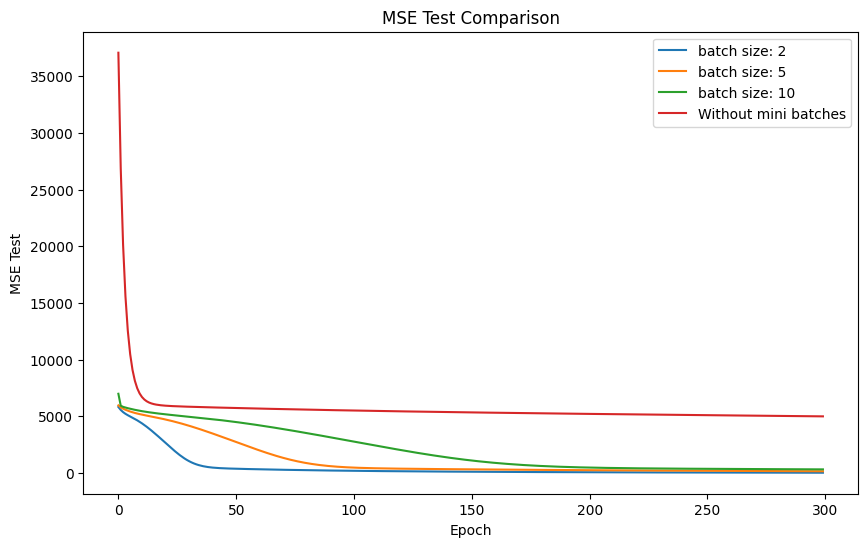

In [325]:
plot_multiple_mse(mse_list)

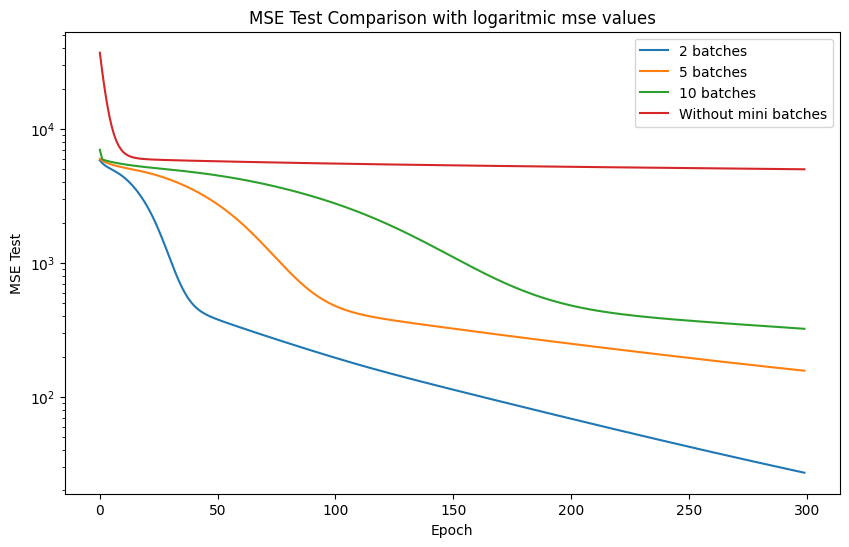

In [291]:
plot_multiple_mse_log(mse_list)

Wnioski

Widzimy, że im większy rozmiar batcha, tym gorzej model sobie radzi

### Inne metody inicjalizowania wag oraz biasów

In [265]:
net_he= Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [266]:
net_he.generate_weights("he")

In [267]:
net_he.SGD(train_data_sq_s,train_data_sq_s, 300, 2, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 7331.663952591883
Epoch 0 complete, mse for test: 5487.79369055297
Epoch 1 complete, mse: 7229.474241824275
Epoch 1 complete, mse for test: 5386.311428016883
Epoch 2 complete, mse: 7150.318070255848
Epoch 2 complete, mse for test: 5320.000851491085
Epoch 3 complete, mse: 7069.415041556953
Epoch 3 complete, mse for test: 5256.708483059147
Epoch 4 complete, mse: 6980.274840695076
Epoch 4 complete, mse for test: 5188.364258481391
Epoch 5 complete, mse: 6879.400040572724
Epoch 5 complete, mse for test: 5111.3089538033355
Epoch 6 complete, mse: 6763.946047933366
Epoch 6 complete, mse for test: 5022.973689470386
Epoch 7 complete, mse: 6631.308736566062
Epoch 7 complete, mse for test: 4921.167544090363
Epoch 8 complete, mse: 6479.136838800009
Epoch 8 complete, mse for test: 4803.970731541192
Epoch 9 complete, mse: 6305.481403435094
Epoch 9 complete, mse for test: 4669.81890003039
Epoch 10 complete, mse: 6108.989549791187
Epoch 10 complete, mse for test: 4517.64886325357

In [278]:
print("MSE dla metody He: ", net_he.mse_test)

MSE dla metody He:  7.863169070565529


In [268]:
net_xa= Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [269]:
net_xa.generate_weights("xavier")

In [270]:
net_xa.SGD(train_data_sq_s,train_data_sq_s, 300, 2, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 7375.645586425641
Epoch 0 complete, mse for test: 5473.973024203076
Epoch 1 complete, mse: 7220.9526329935015
Epoch 1 complete, mse for test: 5334.145295106984
Epoch 2 complete, mse: 7129.396086358059
Epoch 2 complete, mse for test: 5266.441275514264
Epoch 3 complete, mse: 7045.208180046989
Epoch 3 complete, mse for test: 5207.13220461383
Epoch 4 complete, mse: 6955.289889358109
Epoch 4 complete, mse for test: 5142.654697726806
Epoch 5 complete, mse: 6856.166776029722
Epoch 5 complete, mse for test: 5070.337908155405
Epoch 6 complete, mse: 6746.321191747844
Epoch 6 complete, mse for test: 4989.437126574856
Epoch 7 complete, mse: 6624.624998817567
Epoch 7 complete, mse for test: 4899.389328609112
Epoch 8 complete, mse: 6490.127846180086
Epoch 8 complete, mse for test: 4799.621690559081
Epoch 9 complete, mse: 6342.115204208036
Epoch 9 complete, mse for test: 4689.6391983058875
Epoch 10 complete, mse: 6180.193703041923
Epoch 10 complete, mse for test: 4569.126224138

In [279]:
print("MSE dla metody Xavier: ", net_xa.mse_test)

MSE dla metody Xavier:  16.090454568710562


In [271]:
net_unif = Network(sizes = [X_train_sq_s.shape[1], 10, 1])

In [272]:
net_unif.generate_weights("uniform")

In [273]:
net_unif.SGD(train_data_sq_s,train_data_sq_s, 300, 2, 0.05, test_data_sq_s, test_data_sq_s)

Epoch 0 complete, mse: 7969.173422327487
Epoch 0 complete, mse for test: 6172.269812973266
Epoch 1 complete, mse: 7676.125396243954
Epoch 1 complete, mse for test: 5845.333482589697
Epoch 2 complete, mse: 7465.677819840729
Epoch 2 complete, mse for test: 5619.315110677193
Epoch 3 complete, mse: 7310.023166412584
Epoch 3 complete, mse for test: 5461.1741289437705
Epoch 4 complete, mse: 7189.800039375963
Epoch 4 complete, mse for test: 5347.704567269617
Epoch 5 complete, mse: 7090.855011527856
Epoch 5 complete, mse for test: 5261.897494717139
Epoch 6 complete, mse: 7002.952323521305
Epoch 6 complete, mse for test: 5191.533611556809
Epoch 7 complete, mse: 6918.850096158583
Epoch 7 complete, mse for test: 5128.123643342628
Epoch 8 complete, mse: 6833.4794046576
Epoch 8 complete, mse for test: 5065.917196043545
Epoch 9 complete, mse: 6743.259863041745
Epoch 9 complete, mse for test: 5001.048504422953
Epoch 10 complete, mse: 6645.595101620548
Epoch 10 complete, mse for test: 4930.88763341594

In [280]:
print("MSE dla metody Unif[0,1]: ", net_unif.mse_test)

MSE dla metody Unif[0,1]:  21.246472114354933


In [274]:
mse_df_he = pd.DataFrame(net_he.mse_history, columns=['Epoch', 'MSE_Test'])
mse_df_xa = pd.DataFrame(net_xa.mse_history, columns=['Epoch', 'MSE_Test'])
mse_df_unif = pd.DataFrame(net_unif.mse_history, columns=['Epoch', 'MSE_Test'])

In [275]:
mse_list = [(mse_df_he, 'He'), (mse_df_xa, 'Xavier'), (mse_df_unif, 'Unif')]


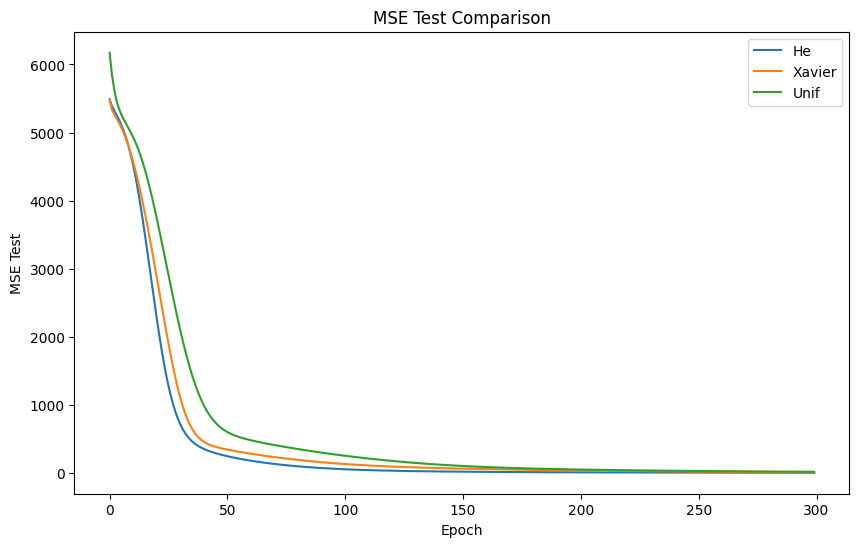

In [276]:
plot_multiple_mse(mse_list)

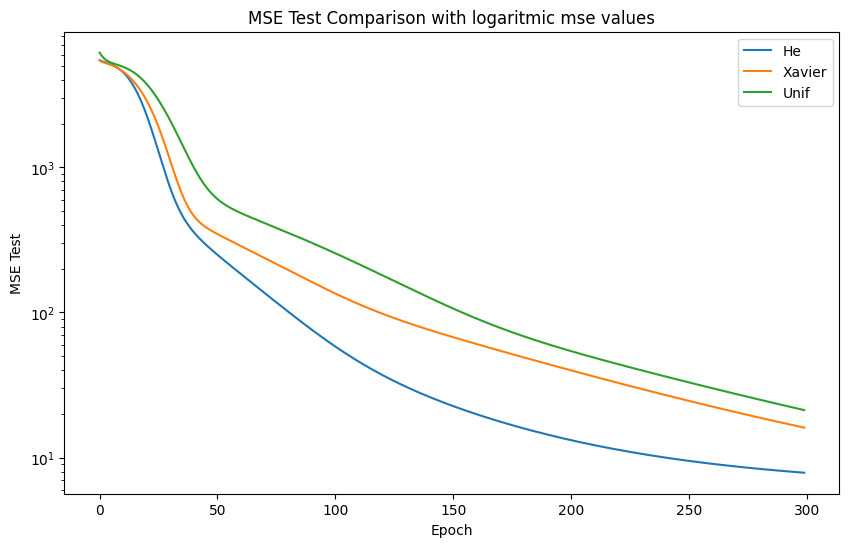

In [277]:
plot_multiple_mse_log(mse_list)

Wnioski:

Widzimy, że najlepiej radzi sobie metoda He. Najgorzej natomiast metoda uniform (która zaznaczę używana była do trenowania wszystkich modeli w pozostałych częsciach zadania)